In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

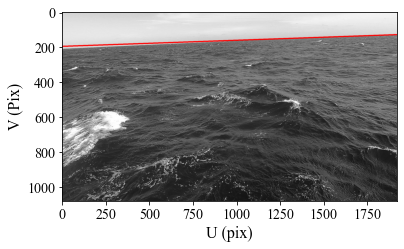

In [2]:
img = cv2.imread("E:/GoPro_deep/image/GH010009.MP4/original_frame242.jpg")

# sharpen the image to make the horizon more clear
sharpen_op = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]],
                      dtype=np.float32)
sharpen_image = cv2.filter2D(img, cv2.CV_32F, sharpen_op)
sharpen_image = cv2.convertScaleAbs(sharpen_image)
gray = cv2.cvtColor(sharpen_image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# noise removal
# dilate the gray image to get rid of the noise
# substruct the images with different dilation degree to get the horizon
# line
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# sure background area
sure_bg = cv2.dilate(closing, kernel, iterations=50)
# sure foreground area
sure_fg = cv2.dilate(closing, kernel, iterations=49)
horizon = cv2.subtract(sure_bg, sure_fg)  # horizon

dst = cv2.Canny(horizon, 100, 255, None, 3)
#cdst1 = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
#cdst2 = cv2.cvtColor(cdst1, cv2.COLOR_BGR2GRAY)

lines = cv2.HoughLines(dst, 0.8, np.pi / 180, 200)
gray_show = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

for rho, theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    rho = rho + 50
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 10000 * (-b))
    y1 = int(y0 + 10000 * (a))
    x2 = int(x0 - 10000 * (-b))
    y2 = int(y0 - 10000 * (a))
    blackboard = np.zeros([1080, 1920])
    horizon_line = cv2.line(gray_show, (x1, y1), (x2, y2), 255, 6)
    
plt.imshow(gray_show)
plt.yticks(fontproperties = 'Times New Roman', size = 14)
plt.xticks(fontproperties = 'Times New Roman', size = 14)

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

plt.xlabel("U (pix)", font)
plt.ylabel("V (Pix)", font)
plt.show()

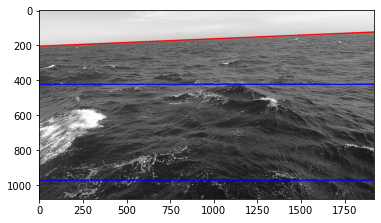

True

In [21]:
img = cv2.imread("E:/GoPro_deep/image/GH010009.MP4/original_frame242.jpg")

# sharpen the image to make the horizon more clear
sharpen_op = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]],
                      dtype=np.float32)
sharpen_image = cv2.filter2D(img, cv2.CV_32F, sharpen_op)
sharpen_image = cv2.convertScaleAbs(sharpen_image)
gray = cv2.cvtColor(sharpen_image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# noise removal
# dilate the gray image to get rid of the noise
# substruct the images with different dilation degree to get the horizon
# line
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# sure background area
sure_bg = cv2.dilate(closing, kernel, iterations=50)
# sure foreground area
sure_fg = cv2.dilate(closing, kernel, iterations=49)
horizon = cv2.subtract(sure_bg, sure_fg)  # horizon

dst = cv2.Canny(horizon, 100, 255, None, 3)

horizon_loc = np.argwhere(dst>0)
horizon_loc_flip = np.flip(horizon_loc, axis=1)
lines = cv2.fitLine(horizon_loc_flip, cv2.DIST_L12, 0, 0.01, 0.01)
lefty = int((-lines[2]*lines[1]/lines[0]) + lines[3])
righty = int(((1920 - lines[2])*lines[1]/lines[0]) + lines[3])

gray_show = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
horizon_line = cv2.line(gray_show, (0, lefty+50), (1920, righty+50), 255, 6)

nv = np.shape(img)[0]
nu = np.shape(img)[1]

lower = max([lefty, righty])
uplimit = int((nv - (lefty + 50))/4 + lefty + 50)
bottomlimit = nv - int(nv/10)


cv2.line(gray_show, (0, uplimit), (1920, uplimit), (0, 0, 255), 6)
cv2.line(gray_show, (0, bottomlimit), (1920, bottomlimit), (0, 0, 255), 6)

plt.imshow(gray_show)
#plt.yticks(fontproperties = 'Times New Roman', size = 14)
#plt.xticks(fontproperties = 'Times New Roman', size = 14)

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

#plt.xlabel("U (pix)", font)
#plt.ylabel("V (Pix)", font)
plt.show()
cv2.imwrite("E:/my-whitecaps/show1.png", gray_show)
#plt.savefig('E:/my-whitecaps/show1.jpg', bbox_inches = 'tight')

In [6]:
def Image2World(u,v,H,roll,pitch,yaw,IntrinsicMatrix):
    """_summary_

    Args:
        u (int): location at the x axis in image coordinate
        v (int): location at the y axis in image coordinate
        H (float): camera height above mean water level
        roll (float): change of the angle of camera around the y axis
        pitch (float): change of the angle of camera around the x axis
        yaw (float): change of the angle of cameraaround the z axis
        IntrinsicMatrix (ndarray): intrinsic matrix of the camera

    The definition is according to the paper:
    Schwendeman, M., & Thomson, J. (2015). 
    A horizon-tracking method for shipboard video stabilization and rectification.
    Journal of Atmospheric and Oceanic Technology, 32(1), 164-176.
    Returns:
        x (float): corresponding x location in real-world coordinate. Unit is m.
        y (float): corresponding y location in real-world coordinate. Unit is m.
        
    """
    R_roll = np.array([[np.cos(roll), -np.sin(roll), 0],
                       [np.sin(roll), np.cos(roll), 0], 
                       [0, 0, 1]])
    R_pitch = np.array([[1, 0, 0], 
                        [0, -np.cos(pitch), -np.sin(pitch)], 
                        [0, np.sin(pitch), -np.cos(pitch)]])
    R_yaw = np.array([[np.cos(yaw), 0, -np.sin(yaw)],
                      [0, 1, 0], 
                      [np.sin(yaw), 0, np.cos(yaw)]])

    R = R_yaw.dot(R_roll.dot(R_pitch))
    # 矩阵求逆
    UV0 = np.array([u, v])
    one = np.ones(u.shape[0])
    UV1 = np.r_[UV0, np.array([one])]
    UV = np.r_[UV1, np.array([one])]

    zero = np.zeros(R.shape[0])
    r = np.c_[R, zero.T]
    rr = np.r_[r, np.array([np.append(zero, 1)])]

    K = np.c_[IntrinsicMatrix, zero.T]
    KK = np.r_[K, np.array([np.append(zero, 1)])]

    a = np.linalg.inv(KK.dot(rr)).dot(UV)

    x = -np.divide(a[0, :], a[2, :]) * H
    y = -np.divide(a[1, :], a[2, :]) * H

    return (x, y)

def Image2Image(u1,v1,roll1,pitch1,yaw1,roll2,pitch2,yaw2,IntrinsicMatrix):
    """_summary_

    Args:
        u1 (_type_): _description_
        v1 (_type_): _description_
        roll1 (_type_): _description_
        pitch1 (_type_): _description_
        yaw1 (_type_): _description_
        roll2 (_type_): _description_
        pitch2 (_type_): _description_
        yaw2 (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """
    R_roll1 = np.array([[np.cos(roll1), -np.sin(roll1), 0],
                        [np.sin(roll1), np.cos(roll1), 0], 
                        [0, 0, 1]])
    R_pitch1 = np.array([[1, 0, 0], 
                         [0, -np.cos(pitch1), -np.sin(pitch1)], 
                         [0, np.sin(pitch1), -np.cos(pitch1)]])
    R_yaw1 = np.array([[np.cos(yaw1), 0, -np.sin(yaw1)],
                       [0, 1, 0], 
                       [np.sin(yaw1), 0, np.cos(yaw1)]])
    R1 = R_yaw1.dot(R_roll1.dot(R_pitch1))

    R_roll2 = np.array([[np.cos(roll2), -np.sin(roll2), 0],
                        [np.sin(roll2), np.cos(roll2), 0], 
                        [0, 0, 1]])
    R_pitch2 = np.array([[1, 0, 0], 
                         [0, -np.cos(pitch2), -np.sin(pitch2)], 
                         [0, np.sin(pitch2), -np.cos(pitch2)]])
    R_yaw2 = np.array([[np.cos(yaw2), 0, -np.sin(yaw2)],
                       [0, 1, 0], 
                       [np.sin(yaw2), 0, np.cos(yaw2)]])
    R2 = R_yaw2.dot(R_roll2.dot(R_pitch2))

    UV0 = np.array([u1, v1])
    one = np.ones(u1.shape[0])
    UV = np.r_[UV0, np.array([one])]
    UV1 = np.r_[UV, np.array([one])]

    zero = np.zeros(R1.shape[0])
    r1 = np.c_[R1, zero.T]
    rr1 = np.r_[r1, np.array([np.append(zero, 1)])]

    zero = np.zeros(R2.shape[0])
    r2 = np.c_[R2, zero.T]
    rr2 = np.r_[r2, np.array([np.append(zero, 1)])]

    K = np.c_[IntrinsicMatrix, zero.T]
    KK = np.r_[K, np.array([np.append(zero, 1)])]

    UV2 = (KK.dot(rr2)).dot(np.linalg.inv(KK.dot(rr1)).dot(UV1))

    u2 = np.divide(UV2[0, :], UV2[2, :])
    v2 = np.divide(UV2[1, :], UV2[2, :])

    return (u2, v2)

def Angle2Line(inc,roll,IntrinsicMatrix):
    """_summary_

    Args:
        inc (_type_): _description_
        roll (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """
    fu = IntrinsicMatrix[0, 0]
    fv = IntrinsicMatrix[1, 1]
    cu = IntrinsicMatrix[0, 2]
    cv = IntrinsicMatrix[1, 2]
    theta = np.arctan(-fu / (fv * np.tan(roll)))
    rho = ((fu * np.sin(roll) * np.cos(theta) - fv * np.cos(roll) *
           np.sin(theta)) / np.tan(inc) 
           + cu * np.cos(theta) + cv * np.sin(theta))
    return (theta, rho)


def Line2Angle(theta,rho,IntrinsicMatrix):
    """_summary_

    Args:
        theta (_type_): _description_
        rho (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """
    fu = IntrinsicMatrix[0, 0]
    fv = IntrinsicMatrix[1, 1]
    cu = IntrinsicMatrix[0, 2]
    cv = IntrinsicMatrix[1, 2]
    roll = np.arctan(-fu / (fv * np.tan(theta)))
    inc = np.arctan((fu * np.sin(roll) * np.cos(theta) 
                     - fv * np.cos(roll) * np.sin(theta)) / 
                    (rho - cu * np.cos(theta) - cv * np.sin(theta)))
    if inc <= 0:
        inc = np.pi + inc

    return (inc, roll)



def Horizon_tracking(img):
    """This function is used to track the horizon.

    Args:
        img (ndarray): input image

    Returns:
        horizonPixel: the location of pixels for horizon
        rho: intercept of the line standing for horizon
        theta: slope of the line standing for horizon
    """
    # sharpen the image to make the horizon more clear
    sharpen_kernel = np.array(
        [[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32)
    sharpen_image = cv2.filter2D(img, cv2.CV_32F, sharpen_kernel)
    
    # cv2.convertScaleAbs help separate foreground and background
    sharpen_image = cv2.convertScaleAbs(sharpen_image)
    gray = cv2.cvtColor(sharpen_image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # dilate the gray image to get rid of the noise 
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # substruct the images with different dilation degree to get the horizon
    sure_bg = cv2.dilate(closing, kernel, iterations=50)
    sure_fg = cv2.dilate(closing, kernel, iterations=49)
    horizon = cv2.subtract(sure_bg, sure_fg)
    
    # use canny algorithm to track the contour profile again
    dst = cv2.Canny(horizon, 100, 255, None, 3)
    # use Hough algorithm to track the line
    lines = cv2.HoughLines(dst, 0.8, np.pi / 180, 200)
    
    # draw the line standing for horizon 
    # TODO(Xin, 2022/6/25): Can make some improvement here
    for rho, theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        rho = rho + 50
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 10000 * (-b))
        y1 = int(y0 + 10000 * (a))
        x2 = int(x0 - 10000 * (-b))
        y2 = int(y0 - 10000 * (a))
        blackboard = np.zeros([1080, 1920])
        horizon_line = cv2.line(blackboard, (x1, y1), (x2, y2), 255, 1)
    horizonPixel = np.argwhere(horizon_line == 255)
    return (horizonPixel, rho, theta)

def StabImage(img,inc1,roll1,azi1,inc2,roll2,azi2,IntrinsicMatrix):
    """_summary_

    Args:
        img (_type_): _description_
        inc1 (_type_): _description_
        roll1 (_type_): _description_
        azi1 (_type_): _description_
        inc2 (_type_): _description_
        roll2 (_type_): _description_
        azi2 (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """

    R_roll1 = np.array([[np.cos(roll1), -np.sin(roll1), 0],
                        [np.sin(roll1), np.cos(roll1), 0], [0, 0, 1]])
    R_pitch1 = np.array([[1, 0, 0], 
         [0, -np.cos(inc1), -np.sin(inc1)], 
         [0, np.sin(inc1), -np.cos(inc1)]])
    R_azi1 = np.array([[np.cos(azi1), 0, -np.sin(azi1)],
                       [0, 1, 0], 
                       [np.sin(azi1), 0, np.cos(azi1)]])
    R1 = R_azi1.dot(R_roll1.dot(R_pitch1))
    R_roll2 = np.array([[np.cos(roll2), -np.sin(roll2), 0],
                        [np.sin(roll2), np.cos(roll2), 0], 
                        [0, 0, 1]])
    R_pitch2 = np.array([[1, 0, 0], 
                         [0, -np.cos(inc2), -np.sin(inc2)], 
                         [0, np.sin(inc2), -np.cos(inc2)]])
    R_azi2 = np.array([[np.cos(azi2), 0, -np.sin(azi2)],
                       [0, 1, 0], [np.sin(azi2), 0, np.cos(azi2)]])
    R2 = R_azi2.dot(R_roll2.dot(R_pitch2))
    R = IntrinsicMatrix.dot(R2).dot(np.linalg.inv(IntrinsicMatrix.dot(R1)))

    stabFrame = cv2.warpPerspective(
        img, R, (np.shape(img)[1], np.shape(img)[0]))

    return (R, stabFrame)
def rectify(img,IntrinsicMatrix,H,incStab,
            rollStab,aziStab,line,rho,theta,roi):
    
    nv = np.shape(img)[0]
    nu = np.shape(img)[1]
    # get the horizon when the camera is stable
    (thetaStab, rhoStab) = Angle2Line(incStab, rollStab, IntrinsicMatrix)


    # get the camera angles at any posture
    (inc, roll) = Line2Angle(theta, rho, IntrinsicMatrix)
    azi = 0

    # stable the image, the horizon will be parallel with the u axis
    (R, stabFrame) = StabImage(img, inc, roll, azi,
                                    incStab, rollStab, aziStab, IntrinsicMatrix)

    # try to get the top view
    uplimit = int((nv - max(line[:, 0]))/4 + max(line[:, 0]))
    bottomlimit = nv - int(nv/10)

    uPoint_init = np.array([0, 0, 1920, 1920])
    vPoint_init = np.array([uplimit, bottomlimit, bottomlimit, uplimit])

    (uPoint0, vPoint0) = Image2Image(uPoint_init, vPoint_init,
                                        roll, inc, azi, rollStab,
                                        incStab, aziStab, IntrinsicMatrix)
    uPoint = np.round(uPoint0 - min(uPoint0))
    vPoint = np.round(vPoint0 - min(vPoint0))

    uPoint_ori = uPoint_init - min(uPoint_init)
    vPoint_ori = vPoint_init - min(vPoint_init)


    (xPoint0, yPoint0) = Image2World(uPoint_init,vPoint_init, H,
                                    roll, inc, azi, IntrinsicMatrix)
    xPoint = xPoint0 - min(xPoint0)
    yPoint = -yPoint0 + max(yPoint0)
    xPoint = np.round(xPoint) * 10
    yPoint = np.round(yPoint) * 10


    pts0 = np.float32([[uPoint_ori[0], vPoint_ori[0]], [uPoint_ori[1], vPoint_ori[1]],
                    [uPoint_ori[2], vPoint_ori[2]], [uPoint_ori[3], vPoint_ori[3]]])
    pts1 = np.float32([[uPoint[0], vPoint[0]], [uPoint[1], vPoint[1]], 
                    [uPoint[2], vPoint[2]], [uPoint[3], vPoint[3]]])
    pts2 = np.float32([[xPoint[0], yPoint[0]], [xPoint[1], yPoint[1]], 
                    [xPoint[2], yPoint[2]], [xPoint[3], yPoint[3]]])

    # image size of the top view image
    xlimit = int(max(xPoint) - min(xPoint))
    ylimit = int(max(yPoint) - min(yPoint))
    # image size of the stable image
    ulimit_stable = int(max(uPoint) - min(uPoint))
    vlimit_Stable = int(max(vPoint) - min(vPoint))

    # get the corresponding ROI in the stabilized frames
    M1 = cv2.getPerspectiveTransform(pts0, pts1)
    a1 = roi 
    # TODO: I need to make this function simpler and better
    dst1 = cv2.warpPerspective(a1,M1,(ulimit_stable, vlimit_Stable))
    # get the rectified ROI
    M2 = cv2.getPerspectiveTransform(pts1, pts2)
    a2 = dst1
    dst2 = cv2.warpPerspective(a2,M2,(xlimit, ylimit))
    return dst2

C:\Users\yang.xin1022\AppData\Local\Temp\ipykernel_84652\173254496.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(-fu / (fv * np.tan(roll)))


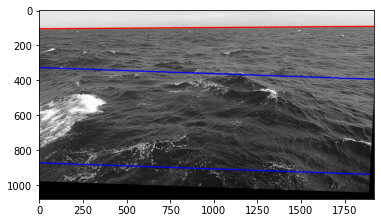

In [28]:
# read in the image
img = cv2.imread("E:/my-whitecaps/show1.png")

# intrinsic matrix of the camera
IntrinsicMatrix = np.array([[1.3533e3, 0, 1.1605e3], 
                            [0, 1.418e3, 529.8685], 
                            [0, 0, 1]])

# camera height
H = 7.0  

# angle of camera when it is stable
incStab = 73 * np.pi / 180
rollStab = 0 * np.pi / 180
aziStab = 0  

# size of the image
nv = np.shape(img)[0]
nu = np.shape(img)[1]

# get the horizon when the camera is stable
(thetaStab, rhoStab) = Angle2Line(incStab, rollStab, IntrinsicMatrix)

# pay attention to the theta here, get the horizon at any posture


# get the camera angles at any posture
(inc, roll) = Line2Angle(theta, rho, IntrinsicMatrix)
azi = 0

# stable the image, the horizon will be parallel with the u axis
(R, stabFrame) = StabImage(img, inc, roll, azi,
                                   incStab, rollStab, aziStab, IntrinsicMatrix)

plt.imshow(stabFrame)

In [29]:
# read in the image
img = cv2.imread("E:/GoPro_deep/image/GH010009.MP4/original_frame242.jpg")

# intrinsic matrix of the camera
IntrinsicMatrix = np.array([[1.3533e3, 0, 1.1605e3], 
                            [0, 1.418e3, 529.8685], 
                            [0, 0, 1]])

# camera height
H = 7.0  

# angle of camera when it is stable
incStab = 73 * np.pi / 180
rollStab = 0 * np.pi / 180
aziStab = 0  

# size of the image
nv = np.shape(img)[0]
nu = np.shape(img)[1]

# get the horizon when the camera is stable
(thetaStab, rhoStab) = Angle2Line(incStab, rollStab, IntrinsicMatrix)

# pay attention to the theta here, get the horizon at any posture
(line, rho, theta) = Horizon_tracking(img)

# get the camera angles at any posture
(inc, roll) = Line2Angle(theta, rho, IntrinsicMatrix)
azi = 0

# stable the image, the horizon will be parallel with the u axis
(R, stabFrame) = StabImage(img, inc, roll, azi,
                                   incStab, rollStab, aziStab, IntrinsicMatrix)

# try to get the top view
uplimit = int((1080 - max(line[:, 0]))/4 + max(line[:, 0]))
bottomlimit = 900
uPoint_init = np.array([0, 0, 1920, 1920])
vPoint_init = np.array([uplimit, bottomlimit, bottomlimit, uplimit])

(uPoint0, vPoint0) = Image2Image(uPoint_init, vPoint_init,
                                    roll, inc, azi, rollStab,
                                    incStab, aziStab, IntrinsicMatrix)
uPoint = np.round(uPoint0 - min(uPoint0))
vPoint = np.round(vPoint0 - min(vPoint0))

uPoint_ori = uPoint_init - min(uPoint_init)
vPoint_ori = vPoint_init - min(vPoint_init)


(xPoint0, yPoint0) = Image2World(uPoint_init,vPoint_init, H,
                                 roll, inc, azi, IntrinsicMatrix)
xPoint = xPoint0 - min(xPoint0)
yPoint = -yPoint0 + max(yPoint0)
xPoint = np.round(xPoint) * 10
yPoint = np.round(yPoint) * 10


pts0 = np.float32([[uPoint_ori[0], vPoint_ori[0]], [uPoint_ori[1], vPoint_ori[1]],
                   [uPoint_ori[2], vPoint_ori[2]], [uPoint_ori[3], vPoint_ori[3]]])
pts1 = np.float32([[uPoint[0], vPoint[0]], [uPoint[1], vPoint[1]], 
                   [uPoint[2], vPoint[2]], [uPoint[3], vPoint[3]]])
pts2 = np.float32([[xPoint[0], yPoint[0]], [xPoint[1], yPoint[1]], 
                   [xPoint[2], yPoint[2]], [xPoint[3], yPoint[3]]])

# image size of the top view image
xlimit = int(max(xPoint) - min(xPoint))
ylimit = int(max(yPoint) - min(yPoint))
# image size of the stable image
ulimit_stable = int(max(uPoint) - min(uPoint))
vlimit_Stable = int(max(vPoint) - min(vPoint))

# get the corresponding ROI in the stabilized frames
M1 = cv2.getPerspectiveTransform(pts0, pts1)
a1 = img[uplimit:bottomlimit, 0:1920]
dst1 = cv2.warpPerspective(a1,M1,(ulimit_stable, vlimit_Stable))
# get the rectified ROI
M2 = cv2.getPerspectiveTransform(pts1, pts2)
a2 = dst1
dst2 = cv2.warpPerspective(a2,M2,(xlimit, ylimit))

C:\Users\yang.xin1022\AppData\Local\Temp\ipykernel_84652\173254496.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(-fu / (fv * np.tan(roll)))


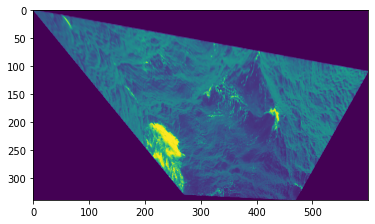

In [30]:
gray_dst2 = cv2.cvtColor(dst2, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_dst2)

In [24]:
rho

195.60000610351562

C:\Users\yang.xin1022\AppData\Local\Temp\ipykernel_84652\173254496.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(-fu / (fv * np.tan(roll)))


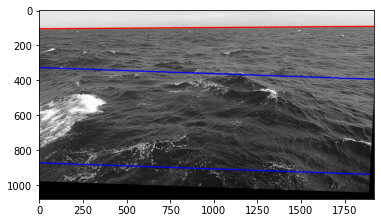

In [31]:
# read in the image
img = cv2.imread("E:/my-whitecaps/show1.png")

# intrinsic matrix of the camera
IntrinsicMatrix = np.array([[1.3533e3, 0, 1.1605e3], 
                            [0, 1.418e3, 529.8685], 
                            [0, 0, 1]])

# camera height
H = 7.0  

# angle of camera when it is stable
incStab = 73 * np.pi / 180
rollStab = 0 * np.pi / 180
aziStab = 0  

# size of the image
nv = np.shape(img)[0]
nu = np.shape(img)[1]

# get the horizon when the camera is stable
(thetaStab, rhoStab) = Angle2Line(incStab, rollStab, IntrinsicMatrix)

# pay attention to the theta here, get the horizon at any posture


# get the camera angles at any posture
(inc, roll) = Line2Angle(theta, rho, IntrinsicMatrix)
azi = 0

# stable the image, the horizon will be parallel with the u axis
(R, stabFrame) = StabImage(img, inc, roll, azi,
                                   incStab, rollStab, aziStab, IntrinsicMatrix)

plt.imshow(stabFrame)

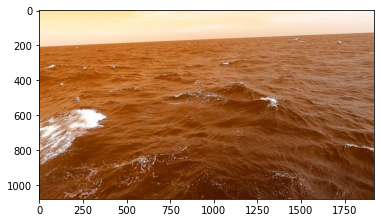

In [33]:
img = cv2.imread("E:/GoPro_deep/image/GH010009.MP4/original_frame242.jpg")
plt.imshow(img)

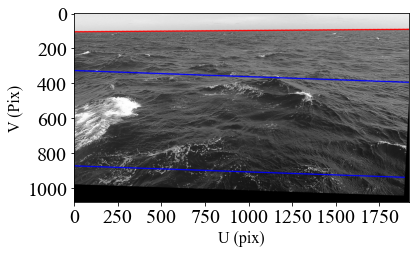

In [39]:
plt.imshow(stabFrame)
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(fontproperties = 'Times New Roman', size = 20)

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

plt.xlabel("U (pix)", font)
plt.ylabel("V (Pix)", font)

plt.savefig('E:/my-whitecaps/show_b.jpg', bbox_inches = 'tight')
plt.show()


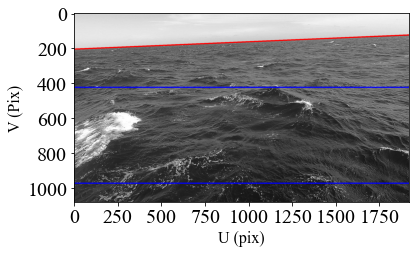

In [42]:
plt.imshow(gray_show)
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(fontproperties = 'Times New Roman', size = 20)

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

plt.xlabel("U (pix)", font)
plt.ylabel("V (Pix)", font)

plt.savefig('E:/my-whitecaps/show_a.jpg', bbox_inches = 'tight')
plt.show()

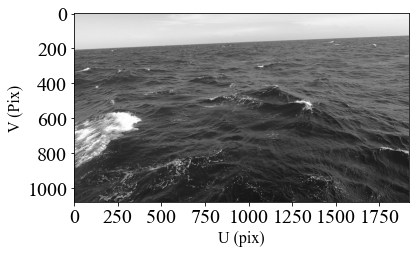

In [44]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(fontproperties = 'Times New Roman', size = 20)

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

plt.xlabel("U (pix)", font)
plt.ylabel("V (Pix)", font)

plt.savefig('E:/my-whitecaps/show_c.jpg', bbox_inches = 'tight')
plt.show()

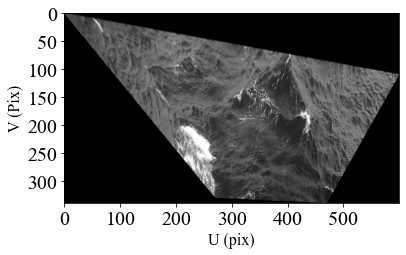

In [45]:
gray_dst2 = cv2.cvtColor(gray_dst2, cv2.COLOR_BGR2RGB)
plt.imshow(gray_dst2)
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(fontproperties = 'Times New Roman', size = 20)

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

plt.xlabel("U (pix)", font)
plt.ylabel("V (Pix)", font)

plt.savefig('E:/my-whitecaps/show_d.jpg', bbox_inches = 'tight')
plt.show()